In [1]:
#!/usr/bin/env python
import numpy as np
import sys
sys.path.insert(0,'./caffe/python')
import caffe
import cv2

def initNet(root_path='./model',device_no=0):
    MODEL_FILE = root_path+'/deploy.prototxt'
    PRETRAINED = root_path+'/train_iter_40000.caffemodel'
    if device_no>=0:
        caffe.set_device(device_no)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)
    return net                       

#process only one image, one can modify it to process a batch of images
def processImage(net,filename):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array([ 104.00698793,  116.66876762,  122.67891434]))
    transformer.set_raw_scale('data', 255)  # images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # channels in BGR order instead of RGB

    img=caffe.io.load_image(filename)
    (H,W,C)=img.shape   #C=3

    #process the image
    imgData=transformer.preprocess('data',img)
    net.blobs['data'].data[...] = imgData
    net.forward()

    outmap=net.blobs['outmap'].data[0,0,:,:]
    map_final=cv2.resize(outmap,(W,H))
    map_final-=map_final.min()
    map_final/=map_final.max()
    map_final=np.ceil(map_final*255)
    return map_final


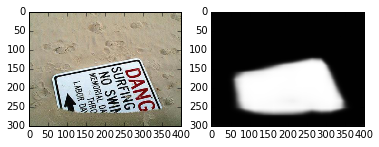

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


net=initNet('./model',0)

filename='./images/input.jpg'
salmap=processImage(net,filename)

mapname='./images/output.png'
cv2.imwrite(mapname,salmap)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')